In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
import pandas as pd

In [49]:
USER = 'user'
BIZ = 'biz'

In [2]:
df_biz = pd.read_csv('cleaned_csv/restaurants.csv')

In [3]:
df = pd.read_csv('csv_by_year/2017.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,business_id,date,review_id,stars,user_id
0,f5O7v_X_jCg2itqacRfxhg,2017-10-12,kS4hrhEScwB9V5JATYjvVQ,5,hxqo4NyJFfeOmuoVi--s1A
1,0bjFYstj8USMzEV4ZQldjA,2017-01-19,VKGvSe0SmYcFc5PqjbxLDQ,5,eG6HneK9zLcuZpVuKcsCGQ
2,gZGsReG0VeX4uKViHTB9EQ,2017-08-16,51RHs_V_fjuistnuKxNpEg,5,5ngpW5tf3ep680eG1HxHzA
3,-bd4BQcl1ekgo7avaFngIw,2017-06-28,P7kiSTiwzqm0_LbA71EOPg,5,5ngpW5tf3ep680eG1HxHzA
4,u73j2VQ3TGWdMO-AG7MABw,2017-07-06,7EgEjUpcb8q-B5dPCMvkaQ,2,5ngpW5tf3ep680eG1HxHzA


In [4]:
def degree(g, nodes=None, as_list=True):
    deg = None
    if nodes:
        deg = dict(g.degree(nodes))
    else:
        deg = dict(g.degree())
    
    if as_list:
        return list(deg.values())
    return deg

def degree_plot(g, nodes, title=''):
    deg = degree(g, nodes)
    hist = np.histogram(deg, bins=100)
    v = range(min(deg), max(deg)+1)
    freqs, edges = hist[0], hist[1]
    n = freqs.size
    means = [(edges[i] + edges[i+1]) / 2 for i in range(n)]
    
    # SCATTER PLOT
    plt.plot(means, freqs, ".")
    plt.xlabel("k")
    plt.ylabel("frequency")
    plt.title("Degree distribution for %s" % title)
    plt.show()
    
    # LOG LOG PLOT
    plt.loglog(means, freqs, ".")
    plt.xlabel("log(k)")
    plt.ylabel("log(frequency)")
    plt.title("Log-log degree distribution for %s" % title)
    plt.show()

In [5]:
cities = set(df_biz.city.str.lower())

In [6]:
df_biz['city'] = df_biz.city.str.lower()

In [7]:
city_counts = dict(df_biz.groupby('city').city.count())

In [8]:
most_popular_city = max(city_counts.keys(), key=lambda k: city_counts[k])

In [9]:
most_popular_city, city_counts[most_popular_city]

('toronto', 9678)

In [10]:
df_toronto = df_biz[df_biz.city == most_popular_city]

In [51]:
biz_toronto = list(df_toronto.business_id)

In [52]:
rev_toronto = df[df.business_id.isin(df_toronto.business_id)]

In [98]:
top20 = rev_toronto.groupby("user_id").filter(lambda x: len(x) > 10)

In [99]:
top20 = top20.groupby("business_id").filter(lambda x: len(x) > 10)

In [100]:
len(set(top20.user_id)), len(top20)

(1100, 12597)

In [101]:
# A politcian class for storing data in a neat way.
class Node:
    def __init__(self, ID, Type):
        self.ID = ID
        self.Type = Type
    
    def to_string(self):
        return "Node (%s), ID: " % (self.Type, self.ID)
    
    def __hash__(self):
        return hash(self.ID)
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.ID == other.ID
               )

In [102]:
biz = list(top20.business_id)
user = list(top20.user_id)

graph = nx.Graph()
for row in top20.itertuples():
    b = Node(row.business_id, BIZ)
    u = Node(row.user_id, USER)
    graph.add_edge(u, b)

In [103]:
len(graph.nodes()), len(graph.edges())

(1705, 12597)

In [104]:
biz_nodes = [n for n in list(graph.nodes()) if n.Type == BIZ]
user_nodes = [n for n in list(graph.nodes()) if n.Type == USER]

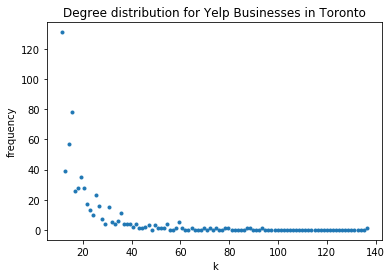

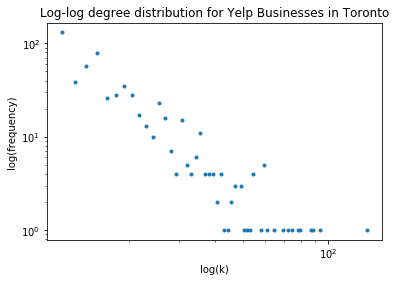

In [105]:
degree_plot(graph, biz_nodes, "Yelp Businesses in Toronto")

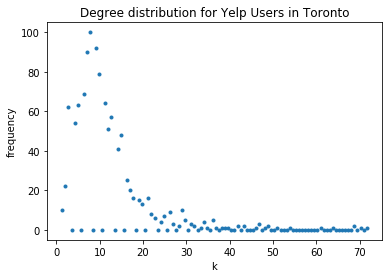

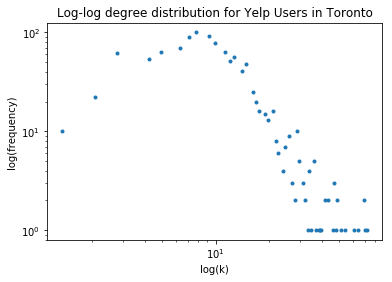

In [106]:
degree_plot(graph, user_nodes, "Yelp Users in Toronto")

In [107]:
ev_centrality = nx.eigenvector_centrality(graph, max_iter=200)

In [108]:
sorted_ev_centrality = sorted(ev_centrality.items(), key=lambda x: x[1], reverse=True)

In [109]:
[(n.ID,v) for n,v in sorted_ev_centrality[:5]]

[('r_BrIgzYcwo1NAuG9dLbpg', 0.17255061884448797),
 ('5aeOewSy4RiI8sLLWpeNGA', 0.12996273645034778),
 ('XYIPXJ9parr9FtvvcGI1SA', 0.11928182611536087),
 ('2pVj1Hid6_Iq3Th9xI0aOQ', 0.11758892196242353),
 ('TibBhm-fbksozIDFD8wjPQ', 0.1155135453821517)]

In [110]:
from fa2l import force_atlas2_layout

In [111]:
nodes = graph.nodes()
degrees = 2 * np.array(degree(graph))
color_map = []
for p in nodes:
    if p.Type == USER: 
        color_map.append("red")
    elif p.Type == BIZ: 
        color_map.append("blue")
    else: 
        color_map.append("#black")

In [112]:
positions = force_atlas2_layout(graph,
                                iterations=1,
                                pos_list=None,
                                node_masses=None,
                                outbound_attraction_distribution=False,
                                lin_log_mode=False,
                                prevent_overlapping=False,
                                edge_weight_influence=1.0,

                                jitter_tolerance=1.0,
                                barnes_hut_optimize=True,
                                barnes_hut_theta=0.5,

                                scaling_ratio=2.0,
                                strong_gravity_mode=False,
                                multithread=False,
                                gravity=1.0)

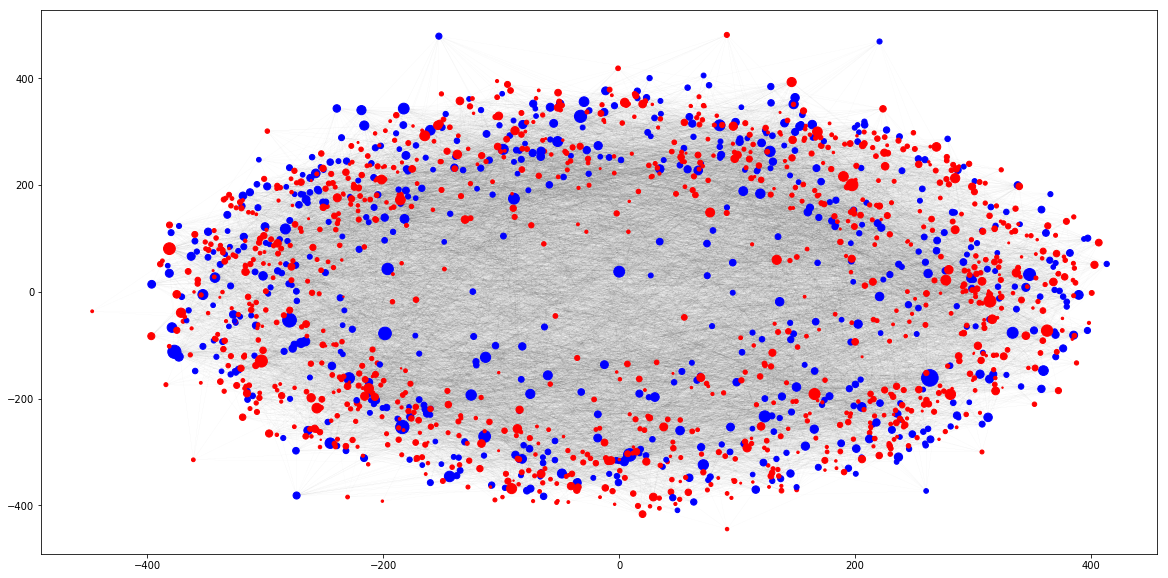

In [124]:
plt.figure(figsize=[20,10])
nx.draw_networkx(graph, positions, with_labels=False, node_color=color_map, node_size=degrees, width=0.01)
plt.show()

In [154]:
B_deg = degree(B, as_list=False)

In [155]:
sort_degree = sorted(deg_biz.items(), key=lambda x: x[1], reverse=True)